# Improving Convolutionalization

Let's see a famous way for improving convolutionalization.

### Problem of convolutionalization

One of the main problems of convolutionalization is that we are decreasing the spatial dimensions of the input images. The output of the segmenter images has much smaller spatial dimensions with respect to the input image. The segmented image has much smaller spatial dimensions.

In the MNIST example, the input image has spatial dimensions $128x128$, while the segmented image has spatial dimensions $16x16$.

Why does this happen? Because the segmenter NN consists in:
- the Conv part taken from the classifier NN. This part decreases the spatial dimensions, for acquiring semantic information and for enlarging the receptive field. At the same time, the channels dimension is enlarged.
- the Dense part taken from the classifier NN, which now consists simply in applying unary Conv layers. This means that the spatial dimensions are unchanged.

So, the reason of the downsampling is the fact that we took the Conv part from the classifier NN, which decreases the spatial dimensions for acquiring semantic information.

This downsampling of the input image is not good. We want to solve that.

### Solution

The solution is quite simple: we modify the segmenter NN in order to upsample the output image.

After the last Dense layer (i.e. unary Conv layer), we put some additonal Conv layers. We add some Conv layers at the end of the segmenter NN. Their aim is to upsample the output image: they increase the spatial dimensions, until reaching the same spatial dimensions of the input image.

For increasing the spatil dimensions, we could use many possible layers. Like **Transposed Conv layers**, with a non-unitarian stride $S>1$.

In this way, segmented image and input image have the same spatial dimensions. They have different channels dimension: the input image has $3$ channels (if colored image); the segmented image has $k$ channels, one for each class.

Typically, the upsampling is done in a symmetric way with respect to the downsampling. Symmetric structure.

Example: modification of a segmenter NN prettu similar to the one seen in the last notebook.

In [4]:
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPool2D, Dense, Conv2DTranspose
from tensorflow.keras import Model

In [13]:
# Input: spatial dimensions 128x128
xin = Input(shape=(128, 128, 1))

# DOWNSAMPLING
# Conv layer: output spatial dimensions 64x64 (stride 2)
x = Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='swish')(xin)
# Conv layer: output spatial dimensions 32x32 (stride 2)
x = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
# Conv layer: output spatial dimensions 16x16 (stride 2)
x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)

# Dense layers (namely, unary Conv layers).
# The spatial dimensions are not changed: 16x16.
x = Dense(units=64, activation = 'swish')(x)
x = Dense(units=11, activation = 'softmax')(x) 

# UPSAMPLING
# Transpose Conv layer: output spatial dimensions 32x32 (stride 2)
x = Conv2DTranspose(filters=11, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
# Transpose Conv layer: output spatial dimensions 64x64 (stride 2)
x = Conv2DTranspose(filters=11, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
# Transpose Conv layer: output spatial dimensions 128x128 (stride 2)
out = Conv2DTranspose(filters=11, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)

# Model
segmenter = Model(inputs=[xin],outputs=[out], name='segmenter')

In [14]:
segmenter.summary()

Model: "segmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dense_10 (Dense)            (None, 16, 16, 64)        4160      
                                                                 
 dense_11 (Dense)            (None, 16, 16, 11)        715       
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 11)       11

**Important things to notice:**
- **Completely symmetric structure: classic Conv layers for decreasing the spatial dimensions, Transpose Conv layers for icnreasing the spatial dimensions**.
- **The final output has dimensions $128x128x11$. SO, same spatial dimensions of the input, but $11$ channels, one for each class.**
- **Each Transpose Conv layer increase the spatial dimensions, but the number of channels is changed: the $11$ channels are preserved.**

**BASICALLY, THIS IS AN AUTOENCODER. IT IS A CONVOLUTIONAL AUTOENCODER. INPUT AND OUTPUT HAVE SAME SPATIAL DIMENSIONS, FIRST PHASE OF COMPRESSION, SECOND PHASE OF DECOMPRESSION**.

### Training the segmenter NN

So, we have described the idea for improving the segmenter NN. This works, and typically it works well.

However, one problem is that now the segmenter NN has additional weigths with respect to the classifier NN. The Transpose conv layers have additional weigths.

So, the weigths loaded from the classifier NN are not anymore enough.

**This implies that we need to explicitely train the segmenter NN. We need to train the segmenter NN.** 

We freeze the part obtained from the classifier NN (we simply load the weigths), and we train the upsampling part.

This implies that we need a segmented dataset (which can be difficult to get).

**ACTUALLY, THERE ARE ALSO UPSAMPLING TECHNIQUES WHICH DON'T HAVE WEIGTHS. IN THIS WAY, WE DON'T NEED TO TRAIN THE SEGMENTER NN.**

## FURTHER IMPROVEMENT: ADDING SKIP CONNECTIONS

We can further improve the current segmenter NN. 

In each upsample layer (i.e. Transpose Conv layer in our case), we add a skip conncetion which comes from the corresponding downsampling layer. Residual connection from each downsampling layer to the corresponding upsampling layer.

It is important to notice that with "corresponding" we mean that the two layers have the same spatial dimensions $W,H$. 

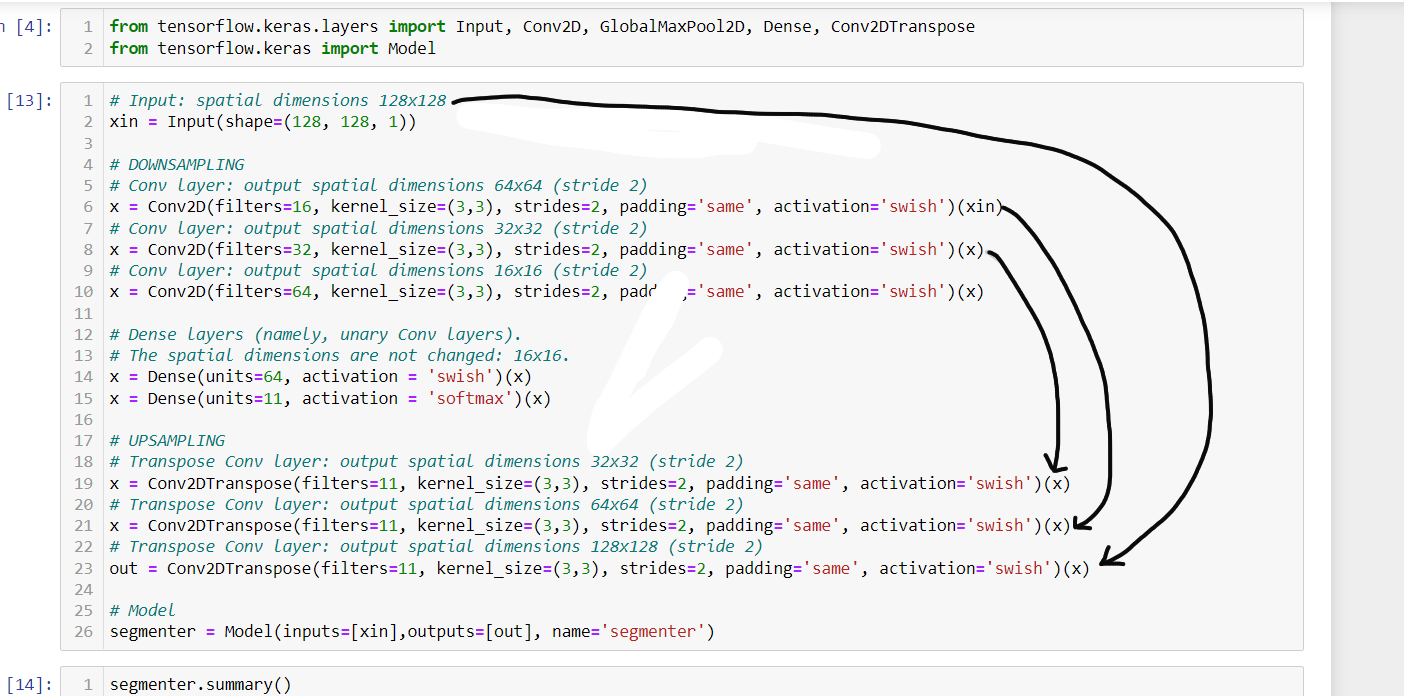

As it can be seen, we are linking the layers which have spatial dimensions $32x32$, the layers which have spatial dimensions $64x64$ and, finally, the layers which have spatial dimensions $128x128$.

### Skip connection

How is actually implemented a skip connection? It somehow combines the outputs of the combines layers. 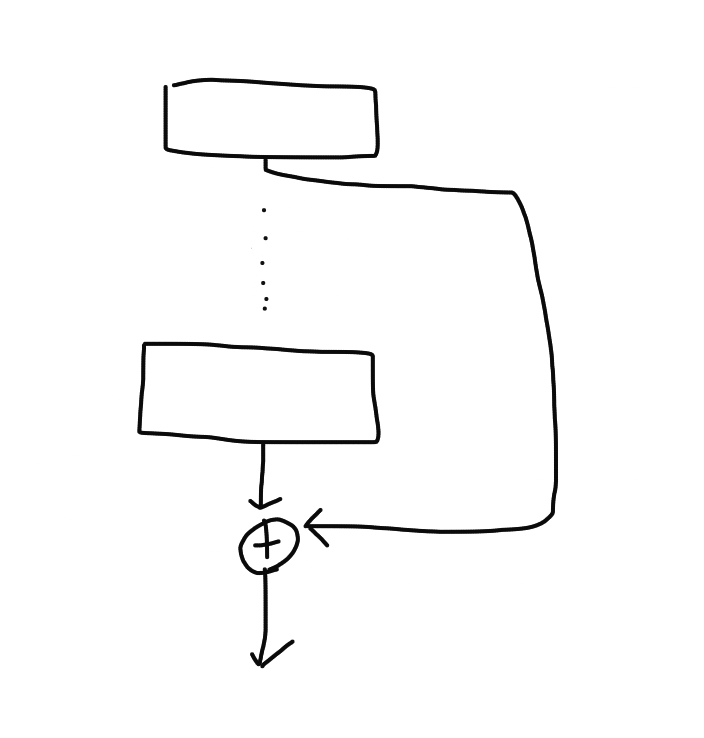

This combination typically consists in adding each pair of corresponding pixels in the two outputs. For doing so, the two outputs must have exact same dimensions $W,H,C$.

By construction of these skip connections, the connected layers have same output spatial dimensions $W,H$.

However, they can have different channels $C$. Indeed, in our example, the connected layers have different channels. For example, if we take the first skip connection, it links a Conv layers which has $32$ output channels with a Transpose Conv layer which has $11$ output channels.

For solving this, we make the number of channels of the downsampling layer (e.g. $32$) equal to the number of channels of the upsampling layer (e.g. $11$): we do that by simply applying an unsary convolution layer.

So, the first skip connection of our example, takes the output of the Conv layer (dimensions $32,32,32$), it trasnforms the number of channels to $11$ (dimensions  $32,32,11$), and it concatenates that to the output of the Transpose Conv layer: the final output of the skip connection have dimensions $32,32,11$, which are the same dimensions of that Transpose layer. 

### Why adding skip connections?

Why are we adding skip connections? Why does this improve the situation?

BEfore, the structure of the segmenter NN was the following.
- Conv part taken from the classifier NN. Decreasing of the spatial dimensions, for acquiring semantic information. We are loosing the spatial dimensions.
- Dense part (which consists in unary Conv layers). In this phase, we have a lot of semantic information, useful for exploiting the features. But we have very veru poor spatial information.
- Upsampling part. We want to upsample the image, to reconstruct the spatial dimensions. But it is very difficult to do so from that situation, since we have very poor spatial information.

For improving that, we add skip connections from the downsampling layer, in order to bring spatial information. With the skip connections, we are mixing the **WHAT** (i.e. semantic infromation) with the **WHERE** (i.e. spatial information).

### Training this segmenter NN

If training the previous segmenter NN was not always necessary, if we use upsample techniques which don't recquire weigths, now instead a stand-alone training of the segmenter NN is necessary. Because there are for sure additional weigths with respect to the classifier NN: thle weigths in the skip connections.

SO, for sure the segmenter NN recquires an additional training.
- We freeze the layers brought from the classifier NN.
- We train the upsampling part and the skip connections.

This implies that we need a segmented dataset (which can be difficult to get).

## U-NET

The next step in improving our situation brings us the U-NET. Which is a very famous architecture.

The idea is simple: since now we have to train the segmenter NN, using a segmented dataset, why don't we simply train a NN from scratch, using that dataset? We don't use a pre-trained classifier NN, but we fully train the segmenter NN from scratch: we only have the segmenter NN.

So, we have a single NN, which is a fully Convolutional NN. It has the structure explained before: encoder-decoderstructure with skip connections.
- Downsampling part. Acquiring semantic information, features extraction, enlarging the receptive field. 
- Upsampling part. Reconstructing the spatial dimensions, with the help of the skip connections from the corresponding downsampling layers.
The output has the same spatial dimensions of the input image, but the number of channels is equal to the number of different classes: $k$.

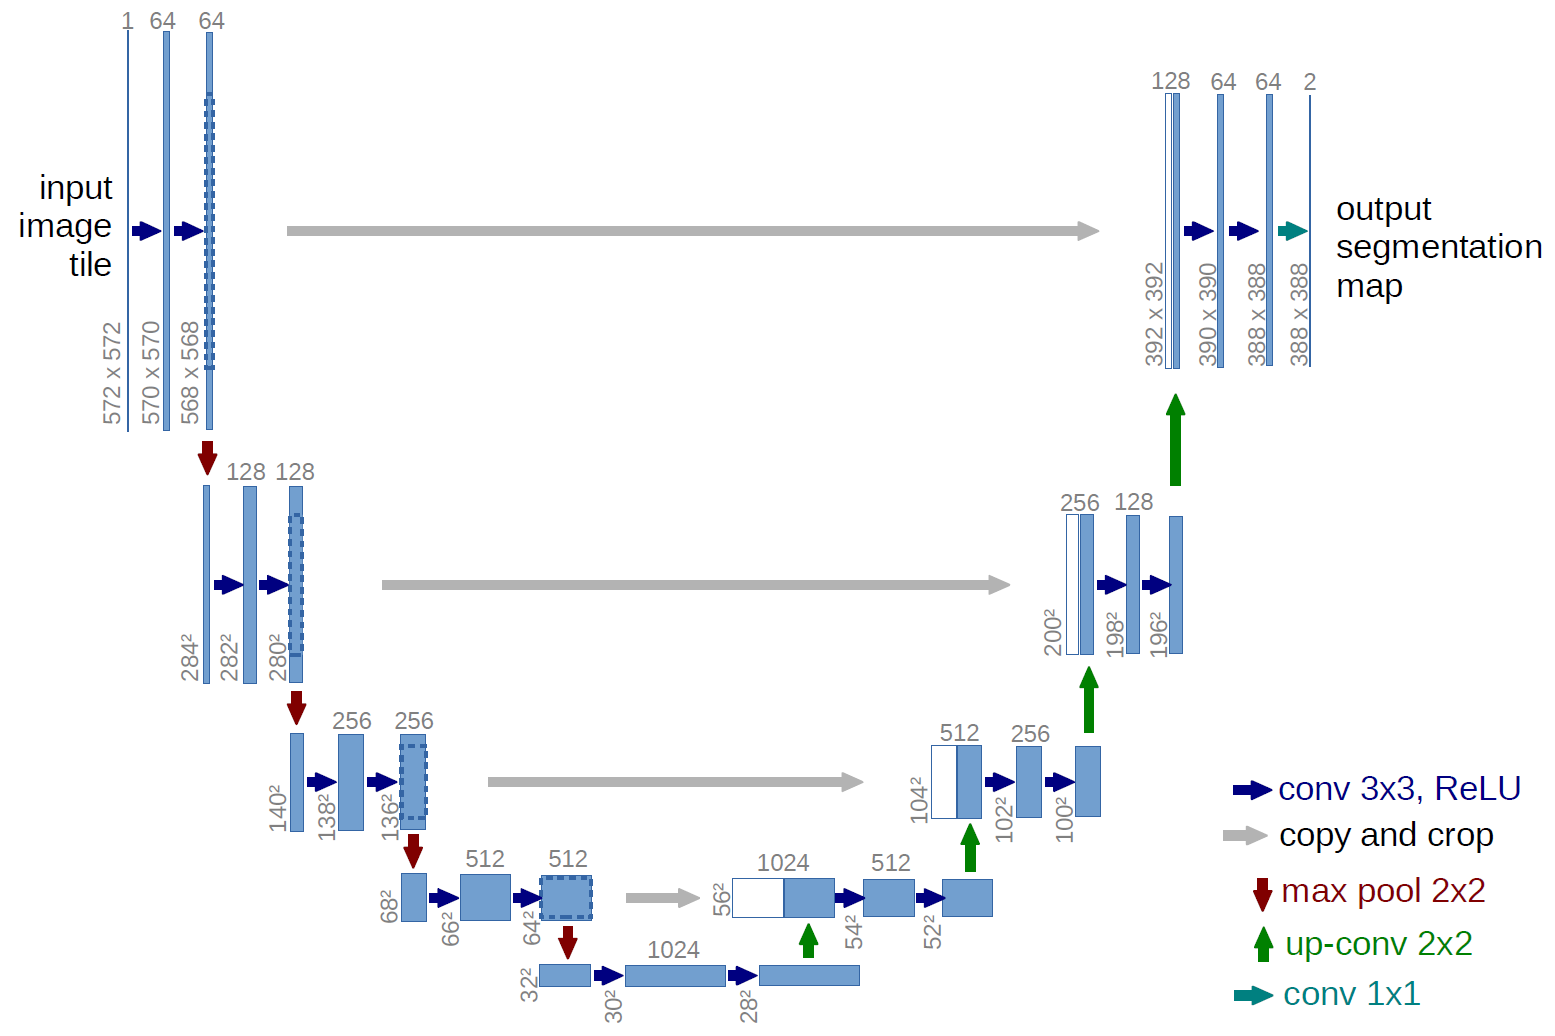
U-shape

**Basically, the U-Net is a Convolutional Autoencoder with skip connections.**

### Why the skip connections?

The reason of the skip connections has been explained before: the skip connections bring spatial information from the downsampling layers to the corresponding upsampling layer, in order to help them the reconstruction of the spatial dimensions from a poor spatial structure.

### Training the U-Net

The U-Net is fully trained from scratch, using a segmented dataset. The ground truth are segmented images. No fixed weigths, no loaded weigths.

**End-to-end training. End-to-end segmentation.**

Completely supervised problem.

### Comparison between "improved convolutionalization" and "U-Net"
- The structure of the two NNs is the same: downsampling (i.e. encoder) + upsampling (i.e. decoder) + skip connections.
- The difference is the following:
    * In the improved convolutionalization, the only weigths that must be learnt are in the skip connections (and in the upsampling part). ALl the other weigths are fixed. The weigths in the encoder are fixed.
    * In the U-NEt, all the weigths must be learnt from scratch.
- Another difference is that the U-Net does not need any pre-trained NN. It does not rely on any pre-trained NN.

The U-Net is simpler to train and to build. But i recquires a segmented dataset for training.

### U-Net: sum up
- Advantages: it does not rely on a classifier, end-to-end segmentation, it can work well with relatively few images.
- Drawback: it needs a segmented dataset.

The encoder part is also called the *"blackbone"*.

### Transfer learning in the U-Net

An U-Net is essentially a encoder-decoder (+ skip connections).

We could apply transfer learning by taking a pre-trained classifier CNN, removing the top, and using it as encoder part of our U-Net.